### Experiment1_Plotting distances and angles
Author : @leopauly | cnlp@leeds.ac.uk <br>
Description : Studying the feature vectors in the feature space

In [1]:
import os
from six.moves import xrange  # pylint: disable=redefined-builtin
import PIL.Image as Image
import random
import numpy as np
import cv2
import time
import math
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input

# Custom scripts
import lscript as lsp
import modelling as md

Using TensorFlow backend.


In [ ]:
height=112 
width=112 
channel=3
crop_size=112

cluster_length=16
feature_size=4608 #8192   #16384  #487
nb_classes=2

batch_size=32
memory_batch_size_train=266
memory_batch_size_test=170
next_batch_start=0
sample_batch_size=10
mean=[123.68, 116.779, 103.939] 

In [ ]:
base_model=md.get_vgg16_imagenet(summary=True,include_fc=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [ ]:
def dotproduct(v1, v2):
  return sum((a*b) for a, b in zip(v1, v2))

def length(v):
  return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
    cos_val=dotproduct(v1, v2) / (length(v1) * length(v2))
    cos_val=float(cos_val)
    cos_val=clean_cos(cos_val)
    angle_in_rad=math.acos(cos_val)
    #print(angle_in_rad)
    return angle_in_rad

def clean_cos(cos_val):
    return min(1,max(cos_val,-1))

In [ ]:
def get_frames_data(filename, num_frames_per_clip=16):
  ''' Given a directory containing extracted frames, return a video clip of
  (num_frames_per_clip) consecutive frames as a list of np arrays '''
  ret_arr = []
  s_index = 0
  for parent, dirnames, filenames in os.walk(filename):
    if(len(filenames)<num_frames_per_clip):
      return [], s_index
    filenames = sorted(filenames)
    s_index = random.randint(0, len(filenames) - num_frames_per_clip)
    for i in range(s_index, s_index + num_frames_per_clip):
      image_name = str(filename) + '/' + str(filenames[i])
      img = Image.open(image_name)
      img_data = np.array(img)
      #lsp.view_image(img_data)
      ret_arr.append(img_data)
  ret_arr=np.array(ret_arr)
  #ret_arr=ret_arr/255
  print('ret_arr',ret_arr.shape)
  #print('ret_arr',ret_arr[1])
  return ret_arr

In [ ]:
## Extraction of features - baseline
def extract_baseline_video_features(vid):
    
    sum_val=0
    for i in range(cluster_length):
        print('vid',vid.shape)
        frame_=vid[i]
        print('frame_',frame_.shape)
        
        #frame_=frame_.reshape(-1,height,width,channel)
        #frame= preprocess_input(frame_) # prepare the image for the VGG model
        
        frame=preprocess(frame_,mean)
        print('frame',frame.shape)
        frame=frame.reshape(-1,height,width,channel)
        
        temp_val=base_model.predict(frame)
        print('temp_val',temp_val.shape)
        temp_val=temp_val.reshape(feature_size)
        #print('temp_val',temp_val.shape)
        sum_val=sum_val+temp_val
        #print('sum_val',sum_val.shape)
    features=sum_val/cluster_length
    #print('feature from one video.shape',features.shape)
    return features

In [ ]:
def preprocess(im,mean):
        im = np.float32(im)
        im[:,:,2] -= 103.939
        im[:,:,1] -= 116.779
        im[:,:,0] -= 123.68
        im = im[:, :, ::-1]  # change to BGR
        return im

In [ ]:
def dist_angle_calc(directory1,directory2):
    baseline_dist=[]
    baseline_angle=[]
    activity_dist=[]
    activitynet_angle=[]
    
    subfolders1=os.listdir(directory1)
    subfolders1=sorted(subfolders1)
    subfolders2=os.listdir(directory2)
    subfolders2=sorted(subfolders2)
    
    for subfolder1_ in subfolders1:
        data1=np.array(get_frames_data(directory1+'/'+subfolder1_))
        print('data1',data1.shape)
        for subfolder2_ in subfolders2:
            data2=np.array(get_frames_data(directory2+'/'+subfolder2_))
            print('data2',data2.shape)
            
            dist_base_=np.linalg.norm(extract_baseline_video_features(data1)-extract_baseline_video_features(data2))
            #dist_act_=activity_model(data1)-activity_model(data2)
            
            baseline_dist.append(dist_base_)
            #activity_dist.append(dist_act_)
            
            angle_base_=angle(extract_baseline_video_features(data1),extract_baseline_video_features(data2))
            #angle_act_=activity_model(data1)-activity_model(data2)
            
            baseline_angle.append(angle_base_)
            #activity_angle.append(dist_angle_)
    
    return baseline_dist,baseline_angle#,activitynet_dist

In [ ]:
## Getting feature space distances for values for similar activity videos
baseline_plot_sim=[]
baseline_plot_angle_sim=[]
activitynet_plot_sim=[]


baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/hit','/nobackup/leopauly/leeds_reordered/hit')
#print(baseline_dist_)
baseline_plot_sim.append([baseline_dist_])
baseline_plot_angle_sim.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/push','/nobackup/leopauly/leeds_reordered/push')
baseline_plot_sim.append([baseline_dist_])
baseline_plot_angle_sim.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/reach','/nobackup/leopauly/leeds_reordered/reach')
baseline_plot_sim.append([baseline_dist_])
baseline_plot_angle_sim.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/pour','/nobackup/leopauly/leeds_reordered/pour')
baseline_plot_sim.append([baseline_dist_])
baseline_plot_angle_sim.append([baseline_angle_])


ret_arr (16, 112, 112, 3)
data1 (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
te

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3

vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data1 (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)


temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
te

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
te

temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
te

vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)


frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)

ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3

frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
te

In [ ]:
baseline_plot_sim=np.array(baseline_plot_sim)
baseline_plot_sim=baseline_plot_sim.reshape(100)
print(baseline_plot_sim)
print(baseline_plot_sim.shape)

[ 265.84509277  650.53375244  610.52044678  617.43786621  660.27410889
  702.70471191  317.03930664  675.32232666  686.74267578  697.62548828
  576.36419678  675.41796875  292.0982666   573.09332275  657.86175537
  797.47521973  955.77026367  594.50115967  196.37661743  636.12042236
  648.47583008  760.5960083   766.76586914  687.81091309    0.
   48.95218658  444.08700562  535.29486084  686.83959961  489.53872681
  403.53634644    0.          473.14819336  522.73748779  490.82989502
  633.00811768  499.33596802   70.08836365  405.74182129  689.25231934
  656.45758057  550.5637207   448.77713013   91.21525574  661.30975342
  495.58914185  469.65686035  449.44845581  278.9468689   113.5690918
  643.85998535  193.38537598  649.05029297  618.49536133  739.82318115
  486.86120605  374.65945435  737.5637207   609.31787109  609.91650391
  663.44683838  647.69390869  237.61024475  346.71911621  568.68218994
  622.75994873  767.4128418   518.36468506  264.65359497  466.3991394
  475.1907959   

In [ ]:
baseline_plot_angle_sim=np.array(baseline_plot_angle_sim)
baseline_plot_angle_sim=baseline_plot_angle_sim.reshape(100)
print(baseline_plot_angle_sim)
print(baseline_plot_angle_sim.shape)

[ 0.27160998  0.66118701  0.62710096  0.6613291   0.68323168  0.72474114
  0.3141414   0.70798892  0.73562231  0.73903627  0.60320119  0.70793775
  0.31000897  0.62618329  0.70004146  0.85162771  0.95013743  0.61335793
  0.20391202  0.67357011  0.67640226  0.74803206  0.81764468  0.74796702
  0.          0.06644348  0.55458656  0.64547618  0.81597789  0.61572544
  0.51533466  0.          0.52200274  0.59655944  0.58186681  0.7449031
  0.56504591  0.07404691  0.43999175  0.77506839  0.77756926  0.62743594
  0.48709731  0.09774279  0.7508657   0.61449513  0.56872614  0.50409224
  0.30403342  0.13247865  0.80617597  0.23535019  0.75178955  0.71793071
  0.92712483  0.60259369  0.45488769  0.88968707  0.71447953  0.78675672
  0.78190025  0.75957311  0.26600312  0.38429405  0.67635264  0.72121334
  0.90409956  0.575191    0.27985395  0.52985749  0.58001324  0.98436574
  0.74064286  0.73257804  0.58166232  0.67828963  1.10370063  1.06955844
  0.93976958  1.23453357  1.15255201  0.32674923  0.

In [ ]:
## Getting feature space distances for values for dissimilar activity videos
baseline_plot_dis=[]
baseline_plot_angle_dis=[]
activitynet_plot_dis=[]


baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/hit','/nobackup/leopauly/leeds_reordered/push')
#print(baseline_dist_)
baseline_plot_dis.append([baseline_dist_])
baseline_plot_angle_dis.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/hit','/nobackup/leopauly/leeds_reordered/reach')
baseline_plot_dis.append([baseline_dist_])
baseline_plot_angle_dis.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/push','/nobackup/leopauly/leeds_reordered/reach')
baseline_plot_dis.append([baseline_dist_])
baseline_plot_angle_dis.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/pour','/nobackup/leopauly/leeds_reordered/reach')
baseline_plot_dis.append([baseline_dist_])
baseline_plot_angle_dis.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/pour','/nobackup/leopauly/leeds_reordered/hit')
baseline_plot_dis.append([baseline_dist_])
baseline_plot_angle_dis.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/pour','/nobackup/leopauly/leeds_reordered/push')
baseline_plot_dis.append([baseline_dist_])
baseline_plot_angle_dis.append([baseline_angle_])

ret_arr (16, 112, 112, 3)
data1 (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data1 (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
te

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

ret_arr (16, 112, 112, 3)
data1 (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (

frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data1 (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

ret_arr (16, 112, 112, 3)
data1 (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data1 (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (

vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)


temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 1

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
ret_arr (16, 112, 112, 3)
data2 (16, 112, 112, 3)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 1

frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
te

temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 

vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)
frame (112, 112, 3)
temp_val (1, 3, 3, 512)
vid (16, 112, 112, 3)
frame_ (112, 112, 3)


In [ ]:
baseline_plot_dis=np.array(baseline_plot_dis)
baseline_plot_dis=baseline_plot_dis.reshape(150)
print(baseline_plot_dis)
print(baseline_plot_dis.shape)

[  722.85095215   739.76965332   657.27075195   614.82177734   829.29064941
   835.88806152   876.49310303   844.90649414   786.60168457   873.0380249
   639.41357422   567.03869629   576.10028076   388.82989502   349.3522644
   664.7199707    607.64996338   708.22247314   652.59240723   619.94976807
   720.33551025   701.89813232   677.3203125    753.96789551   721.02526855
   815.94329834   726.10357666   869.14190674   873.84844971   854.29302979
   788.19390869   829.30291748   887.28619385   885.86590576   864.37915039
   817.61224365   731.10437012   760.77783203   740.51611328   876.70269775
   661.55444336   671.13934326   707.35186768   772.82244873   771.25128174
   755.63043213   705.10723877   855.38696289   829.98797607   787.42553711
   520.8729248    538.06903076   728.22033691   773.70593262   674.99438477
   588.7489624    591.53961182   647.7713623    855.77050781   774.84289551
   693.43493652   772.79595947   798.44036865   763.11236572   830.74822998
   712.5780639

In [ ]:
baseline_plot_angle_dis=np.array(baseline_plot_angle_dis)
baseline_plot_angle_dis=baseline_plot_angle_dis.reshape(150)
print(baseline_plot_angle_dis)
print(baseline_plot_angle_dis.shape)

[ 0.8028863   0.81010579  0.69246002  0.64404323  0.89897389  0.9447759
  0.97647162  0.91460877  0.8282524   0.94403305  0.74208973  0.63656052
  0.64606519  0.41861087  0.37803458  0.76886179  0.68049909  0.78654768
  0.70885079  0.6830849   0.8217344   0.77811523  0.72068706  0.80954933
  0.79253531  0.91078257  0.79661685  0.94243008  0.92354915  0.95211799
  0.86616578  0.91561459  0.94877353  0.94586551  0.96639926  0.95676088
  0.84228506  0.84521319  0.81782261  1.01360135  0.74053354  0.75161277
  0.77971117  0.83593318  0.87210903  0.85602831  0.78676429  0.94352296
  0.89552494  0.91114679  0.6779371   0.6873931   0.88908329  0.90298924
  0.86620028  0.72541881  0.72995935  0.75942579  0.96853434  0.95760176
  0.85059375  0.94431997  0.92763646  0.90687667  1.0158907   0.83217966
  0.86827026  0.73474771  0.90938096  0.90047962  0.87090766  0.9222812
  0.96079661  0.98170077  0.89466831  1.34350596  1.34975557  1.37252726
  1.34146824  1.40132111  1.41431093  1.41369916  1.4

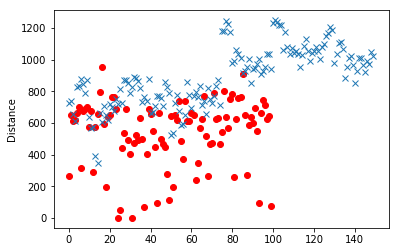

In [ ]:
## Plotting
plt.plot(baseline_plot_sim,'ro')
plt.plot(baseline_plot_dis,'x')
plt.ylabel('Distance')
plt.show()

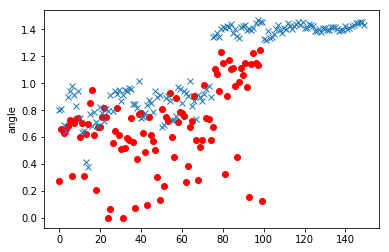

In [ ]:
## Plotting
plt.plot(baseline_plot_angle_sim,'ro')
plt.plot(baseline_plot_angle_dis,'x')
plt.ylabel('angle')
plt.show()